# *Reflective Signatures of Unresolved Objects* - 1D Simulation Notebook

**Notebook Author**: Gregory Nero <br>
**Advisor**: Dr. David Brady <br>
**Contact**: gnero@arizona.edu <br>
**Affiliation**: University of Arizona James C. Wyant College of Optical Sciences <br>
**Last Updated**: March 6 2024  <br>
**Link to Journal Paper**: TBD <br>
**Link to Project Website**: TBD <br>
**Link to Project GitHub**: https://github.com/arizonaCameraLab/reflective-signatures <br>
**Link to Lab Website**: https://arizonacameralab.github.io/

# Important Figure for Reference

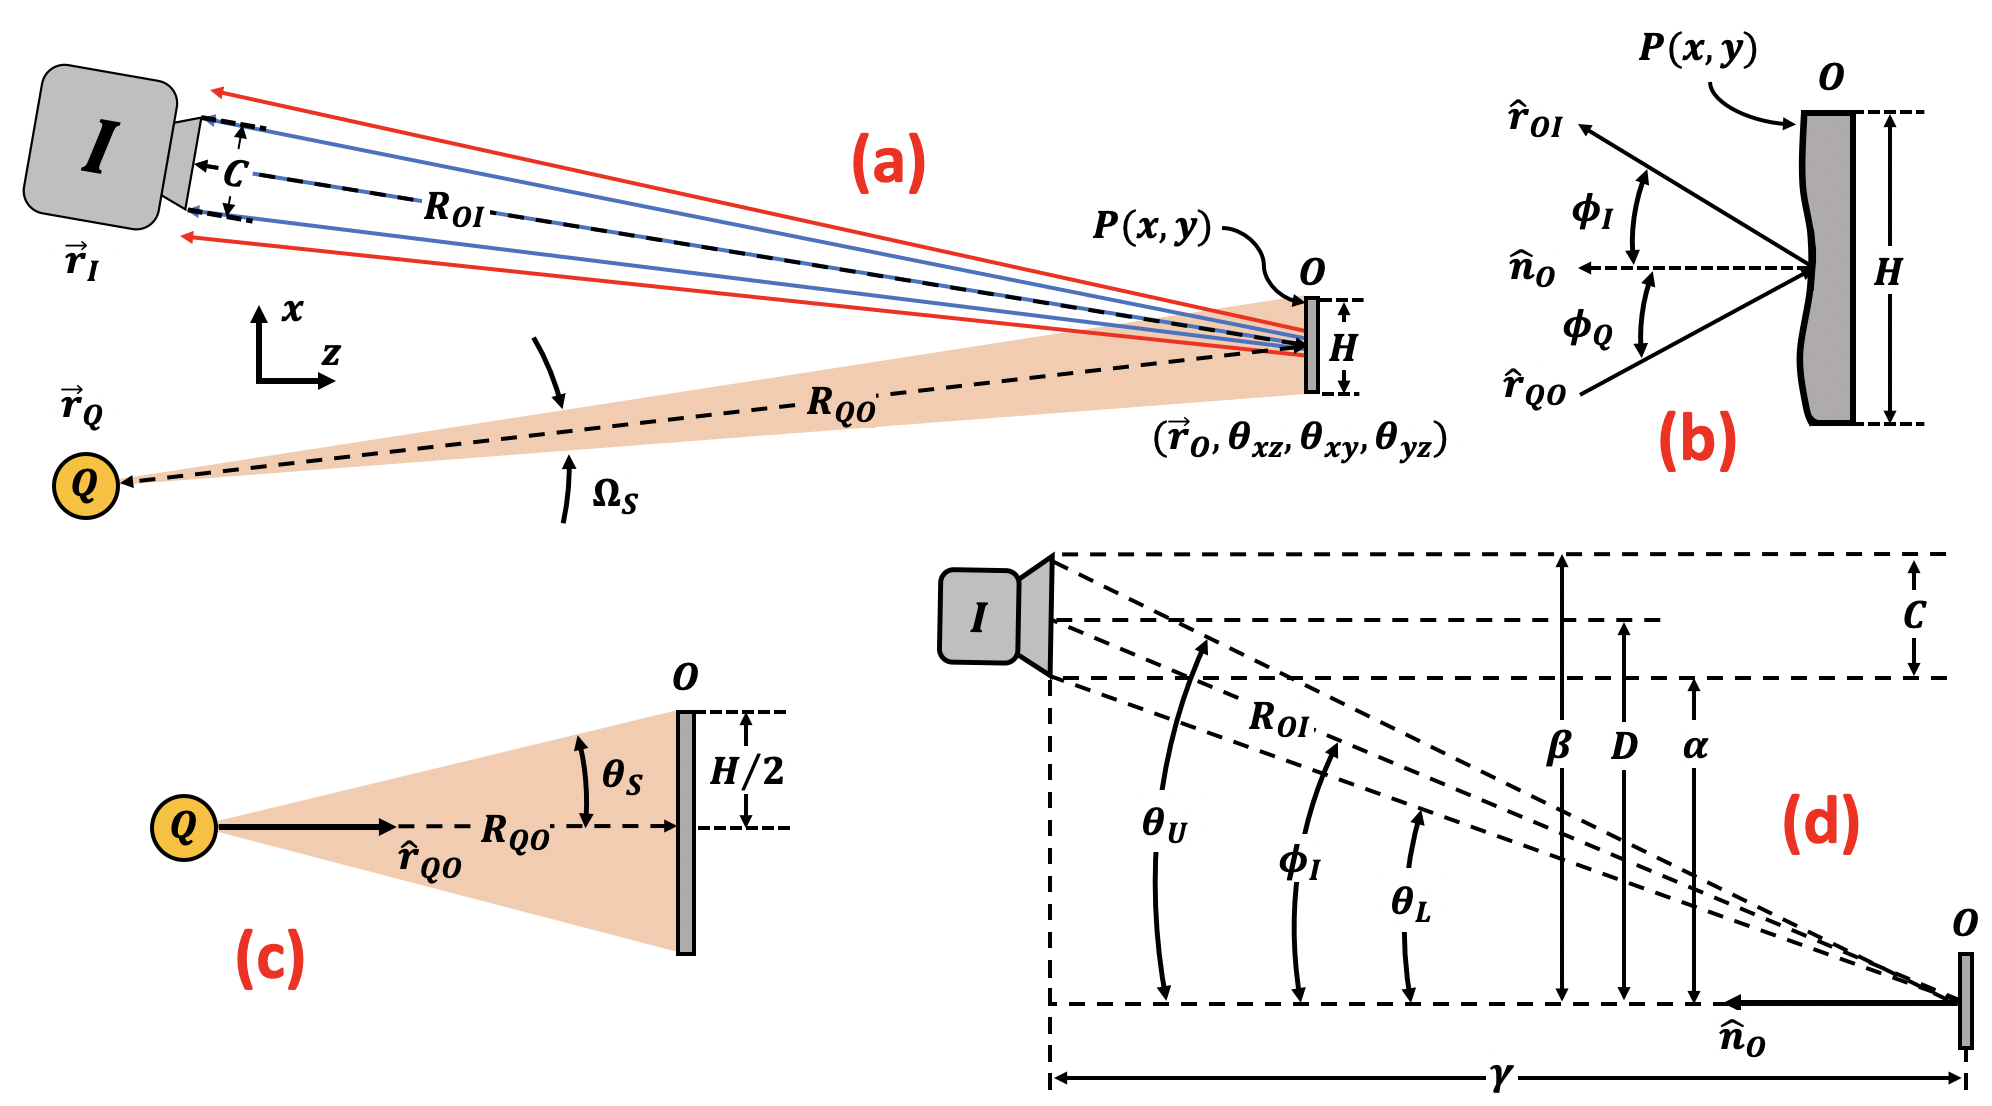

# Import Code Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define Helper Functions

In [2]:
def findReflectedPropagationVector(incident_propagation_vector, surface_normal):

    #  convention for the surface normal: points into the refracting material
    if(np.linalg.norm(incident_propagation_vector) < 0.9999 or np.linalg.norm(surface_normal) < 0.9999 or np.linalg. norm(incident_propagation_vector) > 1.0001 or np.linalg.norm(surface_normal) > 1.0001):

        print("ERROR: INPUT VECTORS MUST BE UNIT VECTORS!")
        return -1

    else:

        A = np.dot(incident_propagation_vector, surface_normal)

        reflected_propagation_vector = incident_propagation_vector - (surface_normal*(2*A))

        if (np.linalg.norm(reflected_propagation_vector) < 0.9999 or np.linalg.norm(reflected_propagation_vector) > 1.0001):

            print("WOAH! YOUR REFLECTED PROPAGATION VECTOR ISN'T UNIT MAGNITUDE!")
            return -1

        else:

            return reflected_propagation_vector

In [3]:
def generateKin_xyplane(angle_from_neg_y):

    # angle_from_neg_y ----> CCW is positive

    b = (90 - angle_from_neg_y) # angle in degrees from +y axis

    x_component = np.cos(b * (np.pi/180))
    y_component = -1*np.sqrt(1 - np.square(x_component))

    k_in = np.array([x_component, y_component])

    k_in = k_in / np.linalg.norm(k_in)

    return k_in

# Define the 1D Forward Model Function

In [4]:
def forwardModel1D(number_of_spatial_sampling_points, domain, surface, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, plotting):

    '''
    Calculate V_i for a single system geometry
    Essentially tells us: how much (if any) signal will we see from some surface given an illumination angle and an observation angle
    Map will specifically tell *which* points on the surface we will detect

    If you want to see the step-by-step plot, turn on plotting
    If you want it to just calculate, turn plotting off

    '''

    # if you want to plot the steps of the simulation, set up some plotting parameters
    if (plotting == True):

        fig, axs = plt.subplots(3, 3, figsize = (10,10), layout="constrained")

        axs00yrange = 0.5
        sizeofreddots = 10
        howmanyarrows = 20
        scale_of_arrows = 5

    # get the gradient of the surface
    dPdx = np.gradient(surface, np.abs(domain[1] - domain[0]))

    tangent_vectors = []
    normal_vectors = []

    # for every point on the surface, get the tangent and normal vector
    for i in range(0, len(dPdx)):

        gradient = dPdx[i]

        tangent_vector = np.array([1, gradient])
        tangent_vector = tangent_vector / np.linalg.norm(tangent_vector)
        tangent_vectors.append(tangent_vector)

        normal_vector = np.dot(np.array([[0, -1], [1, 0]]), tangent_vector)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        normal_vectors.append(normal_vector)

    # define the observation vector
    obs_vector_x = 1*np.tan(observation_angle * (np.pi/180))
    obs_vector_y = np.cos(observation_angle * (np.pi/180))
    obs_vector_base = [obs_vector_x, obs_vector_y]
    obs_vector_base = obs_vector_base / np.linalg.norm(obs_vector_base)
    obs_vector_head = [0,0]

    # generate the input illumination angle
    input_k = generateKin_xyplane(illumination_angle)

    # calculate system geometry parameters (define special case for on-axis observation angle)
    if (observation_angle == 0):

        D = distance_from_obs_to_obj * np.sin(observation_angle * (np.pi/180))
        alpha = D - (aperture_size/2)
        beta = D + (aperture_size/2)
        gamma = distance_from_obs_to_obj
        theta_L = np.arctan(alpha/gamma)
        theta_U = np.arctan(beta/gamma)
        theta_L = theta_L * (180/np.pi)
        theta_U = theta_U * (180/np.pi)


    # calculate system geometry parameters - see paper figure for drawing
    else:

        D = distance_from_obs_to_obj * np.sin(observation_angle * (np.pi/180))
        alpha = D - (aperture_size/2)
        beta = D + (aperture_size/2)
        gamma = D / np.tan(observation_angle * (np.pi/180))
        theta_L = np.arctan(alpha/gamma)
        theta_U = np.arctan(beta/gamma)
        theta_L = theta_L * (180/np.pi)
        theta_U = theta_U * (180/np.pi)


    reflected_vectors = []
    reflected_angles_degrees = []
    signal_vector_map = []

    # for each point on the surface --- (this loop will generate the signal vector for this single system geometry)
    for i in range(0, number_of_spatial_sampling_points):

        # get the reflected vector at that point
        normalvector = normal_vectors[i]
        R = findReflectedPropagationVector(input_k, normalvector)
        R_x_component = R[0]
        reflected_vectors.append(R)

        reflected_angle_radians = np.arccos(np.dot(np.array([0, 1]), R))
        reflected_angle_degrees = reflected_angle_radians * (180/np.pi)

        if (R_x_component < 0): reflected_angle_degrees = -1 * reflected_angle_degrees

        reflected_angles_degrees.append(reflected_angle_degrees)

        # if the reflected angle is within our observation acceptance cone
        if (reflected_angle_degrees <= theta_U and reflected_angle_degrees >= theta_L):

            # receive a signal
            signal_vector_map.append(1)
            if (plotting == True): axs[1,2].scatter(domain[i], surface[i], sizeofreddots, color = 'red')

        # if not
        else:

            # don't recieve a signal
            signal_vector_map.append(0)

    # total signal at this system geometry is sum of all the signals from the surface at that geometry
    # essentailly tells us how many rays we've captured
    sum_of_signal_vector = np.sum(signal_vector_map)

    # define the amount of energy each ray contains - assume unit magnitude and distrbute equally among all rays
    total_energy = 1
    energy_per_ray = total_energy / number_of_spatial_sampling_points

    V_i = energy_per_ray * sum_of_signal_vector # energy per ray * number of rays we have captured

    # BEGIN PLOTTING STUFF
    if (plotting == True):

        for i in range(0,3):

            for j in range(0, 3):

                axs[i,j].grid()
                axs[i,j].axis('equal')

        axs[0,0].set_title("(a) Surface")
        axs[0,0].axis('auto')
        axs[0,0].plot(domain, surface)
        axs[0,0].set_ylim([-1*axs00yrange, axs00yrange])
        axs[0,0].set_xlabel('x [mm]')
        axs[0,0].set_ylabel('y [mm]')


        axs[0,1].set_title("(b) Gradient of Surface")
        axs[0,1].plot(domain, dPdx)
        axs[0,1].set_xlabel('x [mm]')

        for q in np.arange(0, number_of_spatial_sampling_points, int(number_of_spatial_sampling_points/howmanyarrows)):

            xloc = domain[q]
            yloc = surface[q]

            axs[0,2].quiver(xloc, yloc,tangent_vectors[q][0], tangent_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')
            axs[1,0].quiver(xloc, yloc,normal_vectors[q][0], normal_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')
            axs[1,2].quiver(xloc, yloc,reflected_vectors[q][0], reflected_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')

        axs[0,2].set_title("(c) Surface with Tangent Vectors")
        axs[0,2].plot(domain, surface)
        axs[0,2].set_xlabel('x [mm]')

        axs[1,0].set_title("(d) Surface with Normal Vectors")
        axs[1,0].plot(domain, surface)
        axs[1,0].set_xlabel('x [mm]')

        axs[1,1].set_title("(e) Illum. Angle: " + str(np.round(illumination_angle,1)) + " deg from -y")
        axs[1,1].set_xlim([-1.1, 1.1])
        axs[1,1].set_ylim([-1.1, 1.1])
        axs[1,1].quiver(input_k[0], input_k[1],angles='xy', scale=1, scale_units='xy', color='black')
        axs[1,1].set_xticks([])
        axs[1,1].set_yticks([])
        axs[1,1].axhline(y=0, color='k', alpha = 0.5)
        axs[1,1].axvline(x=0, color='k', alpha = 0.5)

        axs[1,2].set_title("(f) Surface with Reflected Vectors")
        axs[1,2].plot(domain, surface)
        axs[1,2].set_xlabel('x [mm]')

        axs[2,0].set_title("(g) Reflected Angles wrt +y")
        axs[2,0].axis('auto')
        axs[2,0].set_ylim([np.min(reflected_angles_degrees)-3, np.max(reflected_angles_degrees)+3])
        axs[2,0].set_ylabel("Degrees")
        axs[2,0].plot(domain, reflected_angles_degrees)
        axs[2,0].hlines(observation_angle, np.min(domain), np.max(domain), color = 'red', linestyle = 'dashed')
        reflected_angle_range = np.abs(np.max(reflected_angles_degrees)-np.min(reflected_angles_degrees))
        qq = reflected_angle_range * 0.1
        axs[2,0].text(-0.75, np.max(reflected_angles_degrees)-(1*qq), "--- Observation Angle: " + str(observation_angle) + " deg", color = 'red', fontsize = 8)
        axs[2,0].text(-0.75, np.max(reflected_angles_degrees)-(2*qq), "lower collection angle: " + str(np.round(theta_L, 2)) + " deg", color = 'red', fontsize = 8)
        axs[2,0].text(-0.75, np.max(reflected_angles_degrees)-(3*qq), "upper collection angle: " + str(np.round(theta_U, 2)) + " deg", color = 'red', fontsize = 8)
        axs[2,0].fill_between(x=domain, y1=theta_U, y2=theta_L, color='red',  interpolate=False, alpha=.2)
        axs[2,0].set_xlabel('x [mm]')

        axs[2,1].set_title("(h) Obs. Angle: " + str(np.round(observation_angle,2)) + " deg from +y")
        axs[2,1].set_xticks([])
        axs[2,1].set_yticks([])
        axs[2,1].axhline(y=0, color='k', alpha = 0.5)
        axs[2,1].axvline(x=0, color='k', alpha = 0.5)
        axs[2,1].set_xlim([-1.1, 1.1])
        axs[2,1].set_ylim([-1.1, 1.1])
        axs[2,1].quiver(0+obs_vector_base[0], 0+obs_vector_base[1], -1*obs_vector_base[0], -1*obs_vector_base[1], angles='xy', scale=1, scale_units='xy', color='black')
        axs[2,1].scatter(obs_vector_base[0], obs_vector_base[1], color = 'red')
        axs[2,1].text(-0.95, -0.57, "size of aperture: " + str(aperture_size) + " mm", color = 'black', fontsize = 8)
        axs[2,1].text(-0.95, -0.7, "distance from obj to obs: " + str(distance_from_obs_to_obj) + " mm", color = 'black', fontsize = 8)

        axs[2,2].set_title("(i) Static State Signal Map \n" + "$V_i = $" + str(np.round(V_i,3)))
        axs[2,2].axis('auto')
        axs[2,2].set_ylim([-0.1, 1.1])
        axs[2,2].plot(domain, signal_vector_map)
        axs[2,2].set_xlabel('x [mm]');

    return V_i

# Define 1D Surfaces and Choose One For Simulation

In [5]:
number_of_spatial_sampling_points = 2048
lower_domain = -1 #mm
upper_domain = 1 #mm
domain = np.linspace(lower_domain, upper_domain, number_of_spatial_sampling_points)

surface_number = 10

if (surface_number == 1): surface = 0.1 *np.cos(4.71238898038*domain) * np.square(np.square(domain - 0.05))
elif (surface_number == 2): surface = 0.1*np.cos(4.71238898038*domain) * np.square(domain - 0.05)
elif (surface_number == 3): surface = 0.2 * (np.power(domain,6) - np.power(domain,4)) * np.square(domain - 0.03) + (0.2*domain * 0.1 * (np.power(domain,6) - np.power(domain,4)) * np.square(domain - 0.03))
elif (surface_number == 4): surface = 0.05 * (np.power(domain,4) - np.power(domain,2)) * np.square((.35*domain) - 1)
elif (surface_number == 5): surface = 0.2 * (np.power(domain,6) - np.power(domain,4)) #***
elif (surface_number == 6): surface = 0.1 * (np.power(domain,4) - np.power(domain,2))
elif (surface_number == 7): surface = 0.008 *np.cos(4.71238898038*domain)
elif (surface_number == 8): surface = 0.008 *np.cos(4.71238898038*domain) * (domain + 0.01)
elif (surface_number == 9): surface = 0.008 *np.cos(4.71238898038*domain) + (0.2*domain*0.008 *np.cos(4.71238898038*domain))
elif (surface_number == 10): surface = 0.2 * (np.power(domain,4) - np.power(domain,2))
elif (surface_number == 11): surface = 0.01 * (np.power(domain,6) - np.power(domain,4)) + (0.003 * domain * (np.power(domain,6) - np.power(domain,4)))
elif (surface_number == 12): surface = 0.05 * (np.power(domain,6) - np.power(domain,4)) * np.square(domain  - 0.1)

# Define Other System Parameters

In [6]:
aperture_size = 50 #mm

illumination_angle = -20 #deg (CCW is +, measured from negative y axis)
observation_angle = -30 #deg (CW is +, measured from positive y axis)

distance_from_obs_to_obj = 5000 #mm

plotting = True

# Run the Static State (Single System Geometry) 1D Forward Model - Generate $V_i$

A note on the interpretation of the value $V_i$ which is returned: <br>

We unit-normalize the energy leaving the surface.<br>
This energy is distributed among all of the rays.<br>
We distribute this among "number_of_spatial_sampling_points" number of rays.<br>
This gives us an energy per ray metric.<br>

Then, $V_i$ is calculated by multiplying the energy per ray metric by the number of rays collected.<br>
So in this way, $V_i$ is representative of the amount of energy collected by the system.<br>

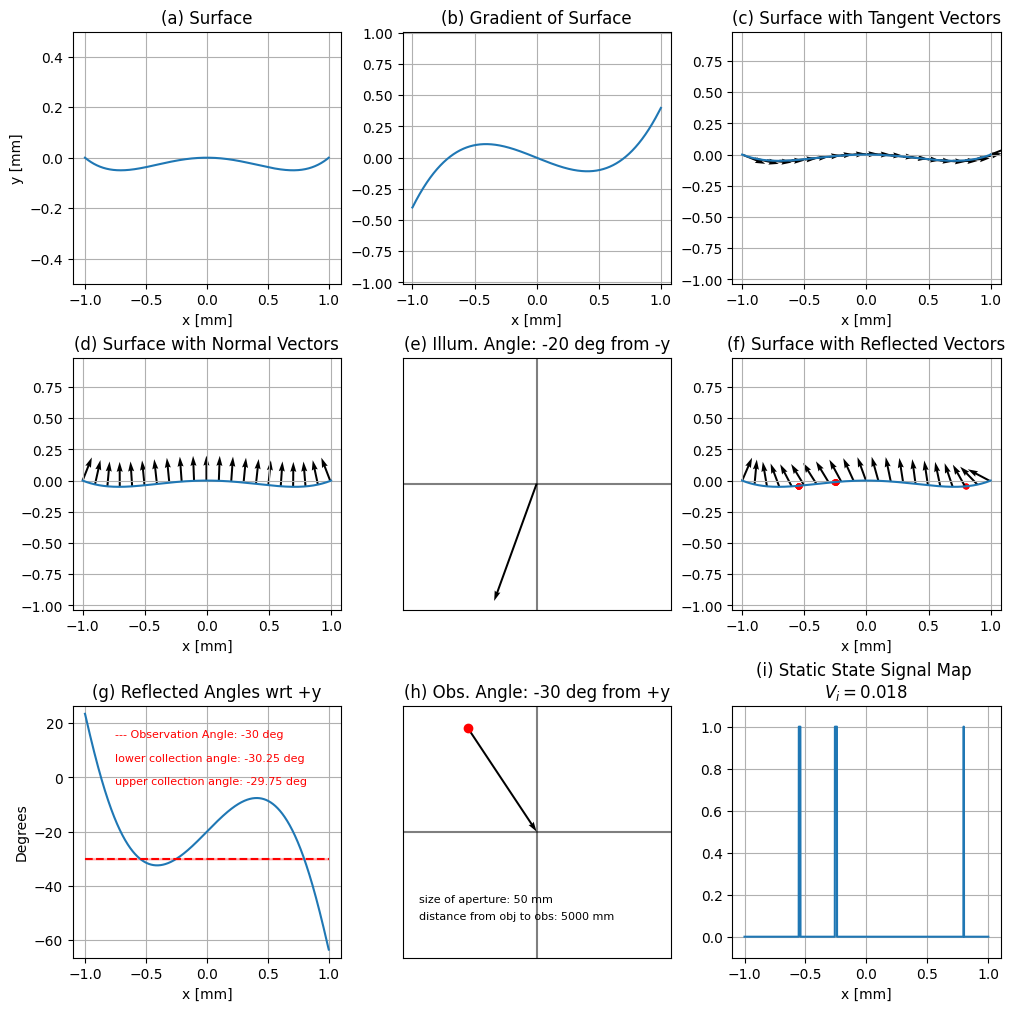

In [7]:
forwardModel1D(number_of_spatial_sampling_points, domain, surface, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, plotting);

# Run the Dynamic Forward Model to Assemble Signal Vector $S_G$

We choose to make the system dynamic by sweeping over a range of observation angles. <br>
Each new observation angle is a new system geometry $g_i$. <br>
We assume that each system geometry is sampled for only one unit of time.

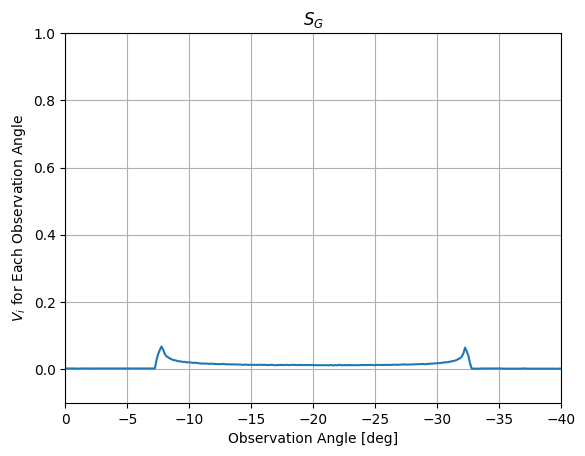

In [8]:
number_of_observation_angles = 300
start_angle = 0
end_angle = -40
observation_angles = np.linspace(start_angle, end_angle, number_of_observation_angles)

S_G = []

for o in range(0, number_of_observation_angles):

    observation_angle = observation_angles[o]

    V_i = forwardModel1D(number_of_spatial_sampling_points, domain, surface, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, False)

    S_G.append(V_i)

fig2, ax = plt.subplots(1,1)
ax.plot(observation_angles, S_G)
ax.set_xlim([start_angle, end_angle])
ax.set_ylim([-0.1, 1])
ax.grid()
ax.set_xlabel("Observation Angle [deg]")
ax.set_ylabel("$V_i$ for Each Observation Angle")
ax.set_title("$S_G$");